# Physiscs Informed Neural Network of Position and Velocity

This notebook demonstrates how to estimate the position and velocity of an object using a Physics Informed Neural Network (PINN).

In [4]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
import numpy as np

In [6]:
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()])
        self.fch = nn.Sequential(*[
            nn.Sequential(*[
                nn.Linear(N_HIDDEN, N_HIDDEN),
                activation()]) for _ in range(N_LAYERS)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [11]:
# Load the data from the specified path
data_url = 'https://raw.githubusercontent.com/jsuarez314/bayesian-ml-physics-lab/refs/heads/main/data/U1.txt'
!wget -nc {data_url}
pathfile = 'U1.txt'
data = np.loadtxt(pathfile)

File ‘U1.txt’ already there; not retrieving.



Learning rate: 0.0002
Data:  226
Step 100000: Loss = 7.776304244995117, Mu = 0.7689899206161499, w0 = 9.724360466003418


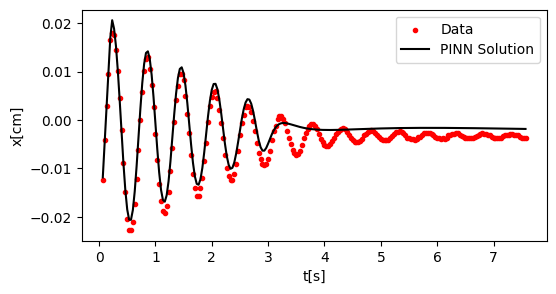

In [13]:
mu_param = []
w0_param = []

torch.manual_seed(123)

mu = torch.nn.Parameter(torch.tensor([0.5], requires_grad=True))  # Iniciar mu con 0.1
w0 = torch.nn.Parameter(torch.tensor([9.], requires_grad=True))  # Iniciar w0 con 0.1
pinn = FCN(1,1,70,7)

optimiser = torch.optim.Adam(list(pinn.parameters()) + [mu, w0], lr=1e-3)

# Coeficientes de ponderación
lambda_physics = 1e2
lambda_data = 1e6  # Puedes ajustar este valor según la importancia relativa

N = 69

for i in range(100001):

    optimiser.zero_grad()

    t = data[:, 0]  # Time data
    x = data[:, 1]  # Position data

    t = torch.tensor(t).float().view(-1, 1)
    x = torch.tensor(x).float().view(-1, 1)

    # Compute physics loss
    t_physics = torch.linspace(t[0].item(), t[-1].item(), N).view(-1, 1).requires_grad_(True)
    t_test = torch.linspace(t[0].item(), t[-1].item(), N).view(-1, 1)

    x_physics = pinn(t_physics)
    dxdt = torch.autograd.grad(x_physics, t_physics, torch.ones_like(x_physics), create_graph=True)[0]
    d2xdt2 = torch.autograd.grad(dxdt, t_physics, torch.ones_like(dxdt), create_graph=True)[0]

    # Nueva pérdida física
    loss_physics = torch.mean((d2xdt2 + mu * dxdt + (w0 ** 2) * x_physics) ** 2)

    # Compute data loss
    xpinn = pinn(t)
    loss_data = torch.mean((xpinn - x) ** 2)

    # Pérdida total
    loss = lambda_physics * loss_physics + lambda_data * loss_data
    loss.backward()

    if loss.item() < 10 and N < data.shape[0]:
      N += 1

    if loss.item() < 100:
      for param_group in optimiser.param_groups:
        param_group['lr'] = 6e-4

    if loss.item() < 20:
      for param_group in optimiser.param_groups:
        param_group['lr'] = 2e-4

    if loss.item() < 1:
      for param_group in optimiser.param_groups:
        param_group['lr'] = 1e-5

    optimiser.step()

    # Record mu and w0 values
    mu_param.append(mu.item())
    w0_param.append(w0.item())

    if i % 100 == 0:

        clear_output(wait=True)
        # Imprimiendo la tasa de aprendizaje
        for param_group in optimiser.param_groups:
          print("Learning rate:", param_group['lr'])

        print('Data: ',N)
        print(f"Step {i}: Loss = {loss.item()}, Mu = {mu.item()}, w0 = {w0.item()}")
        u_test = pinn(t_test).detach()
        plt.figure(figsize=(6, 3))
        #plt.title(f"Training step {i}")
        plt.scatter(t, x, color='r', marker='.',label='Data')
        plt.plot(t_test[:, 0], u_test[:, 0], color='k', label='PINN Solution')
        plt.xlabel('t[s]',fontsize=10)
        plt.ylabel('x[cm]',fontsize=10)
        plt.legend()
        plt.show()
        time.sleep(0.01)

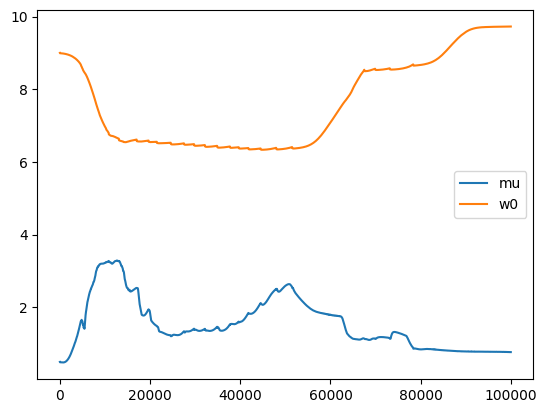

In [14]:
plt.plot(mu_param, label='mu')
plt.plot(w0_param, label='w0')
plt.legend()
plt.show()

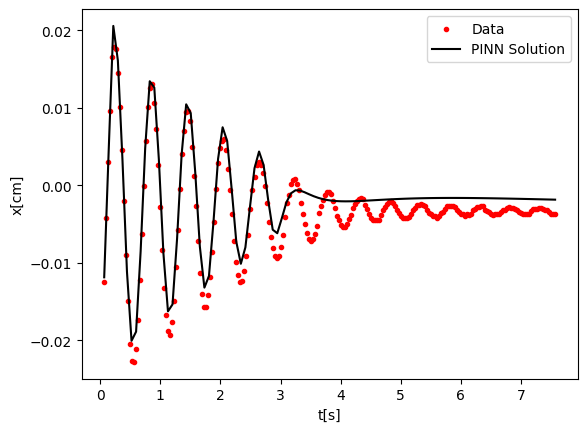

In [18]:
# probando sobre todo el espectro
t1_obs = data[:,0]
u1_obs = data[:,1]

# Conversión a tensores de PyTorch
t1_obs = torch.tensor(t1_obs).float().view(-1, 1)
u1_obs = torch.tensor(u1_obs).float().view(-1, 1)

t1_test = torch.linspace(t1_obs[0].item(), t1_obs[-1].item(), 100).view(-1, 1)
u1_test = pinn(t1_test).detach()

plt.scatter(t1_obs, u1_obs, color='r', marker='.',label='Data')
plt.plot(t1_test[:, 0], u1_test[:, 0], color='k',label='PINN Solution')
plt.xlabel('t[s]',fontsize=10)
plt.ylabel('x[cm]',fontsize=10)
plt.legend()
plt.show()